In [1]:
# fetch the beta-vae synthetic dataset (from the deepmind repo)
!git clone https://github.com/deepmind/dsprites-dataset
!rm -rf .git* *.md LICENSE *.ipynb *.gif *.hdf5

Cloning into 'dsprites-dataset'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.


In [1]:
import torch 
import torch.nn as nn
from torchvision import datasets, transforms, utils
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
## GPU
device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')

SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [3]:
#device='cpu'

In [3]:
from vae import *

## Disentanglement Metric (from B-VAE)

In [4]:
# citation: the below code for visualizing dsprites dataset is from : 
# https://github.com/deepmind/dsprites-dataset/blob/master/dsprites_reloading_example.ipynb
%cd dsprites-dataset
dataset_zip = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='bytes')
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]
position_labels = latents_values[0:32, -1]
orientation_labels = list(set(latents_values[:, -3]))

/scratch/ssd002/home/mhasan/CSC413_FINAL_PROJECT/dsprites-dataset


In [5]:
latents_classes

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  2],
       ...,
       [ 0,  2,  5, 39, 31, 29],
       [ 0,  2,  5, 39, 31, 30],
       [ 0,  2,  5, 39, 31, 31]])

In [6]:
metadata

{b'date': b'April 2017',
 b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.',
 b'version': 1,
 b'latents_names': (b'color',
  b'shape',
  b'scale',
  b'orientation',
  b'posX',
  b'posY'),
 b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
         0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
         1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
         2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
         3.22214631, 3.38325363, 3.54436094, 3.70546826, 3.86657557,
         4.02768

In [7]:
# x = np.where(latents_classes[:, -1] == 1)
# print(f"latent values: {x[0]}")
# print(f"latent classes: {np.take(latents_values, x[0], axis=0)}")
# print(list(set(latents_values[:, -4])))
print(position_labels)

[0.         0.03225806 0.06451613 0.09677419 0.12903226 0.16129032
 0.19354839 0.22580645 0.25806452 0.29032258 0.32258065 0.35483871
 0.38709677 0.41935484 0.4516129  0.48387097 0.51612903 0.5483871
 0.58064516 0.61290323 0.64516129 0.67741935 0.70967742 0.74193548
 0.77419355 0.80645161 0.83870968 0.87096774 0.90322581 0.93548387
 0.96774194 1.        ]


In [8]:
 round(random.uniform(0.5,1), 1)

0.8

In [9]:
# citation: the below code for visualizing dsprites dataset is from : 
# https://github.com/deepmind/dsprites-dataset/blob/master/dsprites_reloading_example.ipynb

latents_sizes = metadata[b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)
    return samples

def show_images_grid(imgs_, num_images=25):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        ax.axis('off')

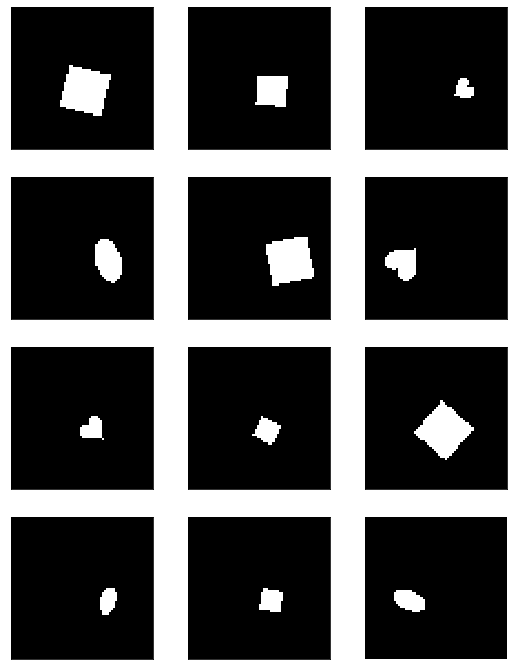

In [10]:
# fixed_factor is the index of the factor we want to keep fixed 
# (i.e. if we want the POS Y fixed we pass in 1)
def sample_dsprites(fixed_factor, batch_size):
    length = 0
    while (length < batch_size):
        fixed_factor = -1 * fixed_factor
        fixed_value = 0
        if (fixed_factor == -1 or fixed_factor == -2):
            fixed_value = random.choice(position_labels)
        elif (fixed_factor == -3):
            fixed_value = random.choice(orientation_labels)
        elif (fixed_factor == -4):
            fixed_value = random.choice([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

        # fixed_indices = latents_values[:, fixed_factor] == fixed_value
        # return latents_values[fixed_indices]
        fixed_indices = np.where(latents_values[:, fixed_factor] == fixed_value)
        fixed_imgs = list(imgs[fixed_indices])
        length = np.shape(fixed_imgs)[0]

    return random.sample(fixed_imgs, batch_size)

# Samples where the scale is the same
x = sample_dsprites(1, 5000)
show_images_grid(x, 12)

In [11]:
class LinClassifier(nn.Module):
    def __init__(self, in_dims, out_dims, layer=nn.Linear):
        super(LinClassifier, self).__init__()
        
        self.net = nn.Sequential(
                layer(in_dims, out_dims)
            )

    #outputs probability logits
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.net(x)
    
        return out

In [12]:
#different method for getting latent z from image x for diff models
#model type = "VAE" or "GAN"
def get_z_from_x(x, model, model_type="VAE"):
    if model_type == "VAE":
        m, log_std= model.encode(x)
        z = model.sample(m, log_std)
        return z

    elif model_type == "GAN":
        return invert_gan_sample(x, model)
    else:
        print("Incorrectly specified model_type, must be 'VAE' or 'GAN'.")
        return None

#for a gan model, find a latent z producing an x similar to one
#provided
#x is a batch of images
def invert_gan_sample(x, generator, num_iter = 100, lr = 1e-3):
    #initialize z from prior p(z) = N(0, I)
    z = torch.randn((x.size(0), generator.latent_dim), requires_grad=True)

    optimizer = torch.optim.Adam([z], lr)

    for iter in range(num_iter):
        optimizer.zero_grad()

        #MSE loss for reconstruction
        recon_loss = ((x - generator(z))**2).sum()

        recon_loss.backward()
        optimizer.step()

        print("GAN inversion loss: {}, iteration : {}/{}".format(recon_loss, iter, num_iter))

    return z


In [41]:
def get_classifier_batch(batch_size, sub_batch_size, model, model_type):
    #batch size is the "upper" batch size 
    #we have batch_size number of unique labels
    #each has a "sub_batch_size" number of images
    labels = np.random.randint(1,5, size=batch_size)
    classifier_inp_batch = torch.zeros((batch_size, model.latent_dim))
    for i in range(batch_size):
        sub_batch_x = sample_dsprites(labels[i], 2*sub_batch_size)

        sub_batch_x = torch.Tensor(sub_batch_x).float().view((-1, 1, 64, 64))
        
        #get z for subbatch
        sub_batch_z = get_z_from_x(sub_batch_x, model, model_type)
        
        #we use z_avg as the input to classifier
        z_avg = (sub_batch_z[:sub_batch_size,:] - sub_batch_z[sub_batch_size:,:]).mean(dim=0)

        classifier_inp_batch[i,:] = z_avg

    return classifier_inp_batch, torch.Tensor(labels-1).long()

In [62]:
def classifier_val_acc(num_val_epochs, num_batches_per_val_epoch, model,model_type, lin_classifier):
    for epoch in range(num_val_epochs):
        val_acc = 0.0
        num_batch = 0
        
        batch_size = 1
        
        for i in range(num_batches_per_val_epoch):
            
            #print("SAMPLING")
            classifier_inp_batch, labels = get_classifier_batch(batch_size, 
                                                        sub_batch_size=4, 
                                                        model=model,
                                                        model_type =model_type)
            
            #print("SAMPLED")
            pred_logits = lin_classifier(classifier_inp_batch)
            pred_labels = torch.argmax(pred_logits, dim=1)

            num_correct = (pred_labels == labels).sum().float()
            acc = num_correct/batch_size

            val_acc += acc.item()
            num_batch += 1
            
            #print("Done 1 iteration of validation")
        return val_acc/num_batch

def train_lin_classifier(config, lin_classifier, model, model_type):
    c_optimizer = torch.optim.Adam(lin_classifier.parameters(), config["lr"])

    #lin_classifier = lin_classifier.to(device)
    #model = model.to(device)

    num_epochs = config["epoch"]

    epoch_loss = torch.zeros(num_epochs)
    val_acc = torch.zeros(num_epochs)

    num_train_batches_per_epoch = 10

    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):

        epoch_loss[epoch] = 0.0
        batch_size = 0

        for i in range(num_train_batches_per_epoch):
            #print("TRAIN SAMPLING")
            classifier_inp_batch, labels = get_classifier_batch(config["batch"], 
                                                        sub_batch_size=4, 
                                                        model=model,
                                                        model_type =model_type)
            #print("TRAIN SAMPLING DONE")
            pred_logits = lin_classifier(classifier_inp_batch)
            
            #print(pred_logits.size())
            #print(labels.size())
            loss_val = criterion(pred_logits, labels)

            c_optimizer.zero_grad()
            loss_val.backward()
            c_optimizer.step()

            batch_size += 1
            epoch_loss[epoch] += loss_val.item()
            
            #print("Done 1 iteration of training")
            
        epoch_loss[epoch] = epoch_loss[epoch]/batch_size
        
        #print("Validation accuracy now")
        
        #compute val_loss
        val_acc[epoch] =classifier_val_acc(1,num_batches_per_val_epoch=10,
                                           model= model,
                                           model_type=model_type,
                                          lin_classifier = lin_classifier)
        
        print("Epoch {}/{} -- Train loss: {}, Val Acc: {}".format(epoch+1, num_epochs, epoch_loss[epoch], val_acc[epoch]))
    
    return val_acc
    

In [60]:
def disentangle_metric(lin_classifier, model, model_type):
    classifier_config = {
        "epoch": 20,
        "lr": 1e-4,
        "batch": 1
    }

    #train classifier
    val_acc = train_lin_classifier(classifier_config, lin_classifier, model, model_type)
    
    #report final val accuract as metric, on each type of factor
    return val_acc[-1]

In [24]:
#linear classifier for dsprites data set must predict from one of 4 factors
LATENT_DIMS = 10
factor_classifier = LinClassifier(in_dims= LATENT_DIMS, out_dims=4)


In [25]:
vae_model = VAEConv(latent_dim =10, n_channels=1)

In [26]:
torch.cuda.empty_cache()

In [27]:
vae_model.load_state_dict(torch.load("/h/mhasan/CSC413_FINAL_PROJECT/weights/VAE_dsprites_weights"))

<All keys matched successfully>

In [27]:
vae_model.to('cpu')

VAEConv(
  (e_conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (e_conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (e_conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (e_conv4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (e_conv5): Conv2d(64, 256, kernel_size=(4, 4), stride=(1, 1))
  (e_fc_mean): Linear(in_features=256, out_features=10, bias=True)
  (e_fc_log_std): Linear(in_features=256, out_features=10, bias=True)
  (d_fc1): Linear(in_features=10, out_features=256, bias=True)
  (d_conv1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
  (d_conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d_conv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d_conv4): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d_conv5): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padd

In [32]:
dis_score =  disentangle_metric(factor_classifier, vae_model, "VAE")

Epoch 1/10 -- Train loss: 1.3608276844024658, Val Acc: 0.20000000298023224
Epoch 2/10 -- Train loss: 1.4089428186416626, Val Acc: 0.30000001192092896
Epoch 3/10 -- Train loss: 1.442596435546875, Val Acc: 0.30000001192092896
Epoch 4/10 -- Train loss: 1.4392997026443481, Val Acc: 0.20000000298023224
Epoch 5/10 -- Train loss: 1.5347703695297241, Val Acc: 0.20000000298023224
Epoch 6/10 -- Train loss: 1.444217324256897, Val Acc: 0.30000001192092896
Epoch 7/10 -- Train loss: 1.424702763557434, Val Acc: 0.30000001192092896
Epoch 8/10 -- Train loss: 1.4058183431625366, Val Acc: 0.30000001192092896
Epoch 9/10 -- Train loss: 1.46112060546875, Val Acc: 0.20000000298023224
Epoch 10/10 -- Train loss: 1.3980923891067505, Val Acc: 0.20000000298023224


In [38]:
dis_score =  disentangle_metric(factor_classifier, vae_model, "VAE")

Epoch 1/10 -- Train loss: 1.4291788339614868, Val Acc: 0.2750000059604645
Epoch 2/10 -- Train loss: 1.4581166505813599, Val Acc: 0.265625
Epoch 3/10 -- Train loss: 1.2920076847076416, Val Acc: 0.2562499940395355
Epoch 4/10 -- Train loss: 1.3813661336898804, Val Acc: 0.25312501192092896
Epoch 5/10 -- Train loss: 1.3829975128173828, Val Acc: 0.24375000596046448
Epoch 6/10 -- Train loss: 1.4744945764541626, Val Acc: 0.26249998807907104
Epoch 7/10 -- Train loss: 1.3351709842681885, Val Acc: 0.23749999701976776
Epoch 8/10 -- Train loss: 1.4492055177688599, Val Acc: 0.21875
Epoch 9/10 -- Train loss: 1.3945523500442505, Val Acc: 0.3062500059604645
Epoch 10/10 -- Train loss: 1.3883483409881592, Val Acc: 0.28125


In [63]:
dis_score =  disentangle_metric(factor_classifier, vae_model, "VAE")

Epoch 1/20 -- Train loss: 1.4636067152023315, Val Acc: 0.4000000059604645
Epoch 2/20 -- Train loss: 1.4684526920318604, Val Acc: 0.20000000298023224
Epoch 3/20 -- Train loss: 1.4953031539916992, Val Acc: 0.4000000059604645
Epoch 4/20 -- Train loss: 1.460712194442749, Val Acc: 0.30000001192092896
Epoch 5/20 -- Train loss: 1.3878238201141357, Val Acc: 0.4000000059604645
Epoch 6/20 -- Train loss: 1.2446112632751465, Val Acc: 0.20000000298023224
Epoch 7/20 -- Train loss: 1.4030139446258545, Val Acc: 0.30000001192092896
Epoch 8/20 -- Train loss: 1.4187142848968506, Val Acc: 0.30000001192092896
Epoch 9/20 -- Train loss: 1.5934044122695923, Val Acc: 0.30000001192092896
Epoch 10/20 -- Train loss: 1.3305953741073608, Val Acc: 0.4000000059604645
Epoch 11/20 -- Train loss: 1.4523532390594482, Val Acc: 0.4000000059604645
Epoch 12/20 -- Train loss: 1.431390643119812, Val Acc: 0.20000000298023224
Epoch 13/20 -- Train loss: 1.397646427154541, Val Acc: 0.30000001192092896
Epoch 14/20 -- Train loss: 1.

In [ ]:
dis_score =  disentangle_metric(factor_classifier, vae_model, "VAE")

In [65]:
avg_acc = 0
for i in range(10):
    classifier_inp_batch, labels = get_classifier_batch(4, 
                                                            sub_batch_size=5, 
                                                            model=vae_model,
                                                            model_type ="VAE")

    logits = factor_classifier(classifier_inp_batch)
    pred = torch.argmax(logits, dim=1)
    num_correct = (pred == labels).sum().float()
    acc = num_correct/4
    print("Accuracy: {}".format(acc))
    avg_acc += acc
    
avg_acc/10

Accuracy: 0.5
Accuracy: 0.25
Accuracy: 0.0
Accuracy: 0.25
Accuracy: 0.25
Accuracy: 0.25
Accuracy: 0.5
Accuracy: 0.25
Accuracy: 0.25
Accuracy: 0.5


tensor(0.3000)

In [54]:
labels

tensor([0, 3, 0, 2])

In [55]:
classifier_inp_batch.size()

torch.Size([4, 10])

In [56]:
logits = factor_classifier(classifier_inp_batch)

In [57]:
logits

tensor([[ 0.1538, -0.2941,  0.3927, -0.2490],
        [-0.2434, -0.0903, -0.6815,  0.0502],
        [ 0.3755,  0.1373, -0.1019,  0.0766],
        [ 0.7678, -0.0672,  0.3960, -0.0888]], grad_fn=<AddmmBackward>)

In [58]:
pred = torch.argmax(logits, dim=1)

In [59]:
pred

tensor([2, 3, 0, 0])

In [51]:
num_correct = (pred == labels).sum().float()
acc = num_correct/4

In [52]:
acc

tensor(0.7500)

In [105]:
vae_dsprites.to('cpu')
sampled_ims_pre = vae_dsprites.sample_ims_from_prior(num_ims=5, train=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


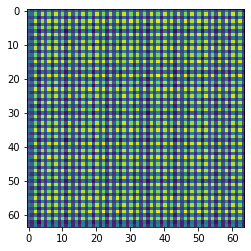

In [107]:
plt.imshow(F.sigmoid(sampled_ims_pre[0,:,:]).squeeze().detach().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1/50 -- Train loss: 80.44981384277344
Epoch 2/50 -- Train loss: 77.05050659179688
Epoch 3/50 -- Train loss: 75.21749877929688
Epoch 4/50 -- Train loss: 74.42823028564453
Epoch 5/50 -- Train loss: 72.97116088867188
Epoch 6/50 -- Train loss: 72.01223754882812
Epoch 7/50 -- Train loss: 70.90728759765625
Epoch 8/50 -- Train loss: 69.9815444946289
Epoch 9/50 -- Train loss: 69.18295288085938
Epoch 10/50 -- Train loss: 68.69573211669922
Epoch 11/50 -- Train loss: 67.69110870361328
Epoch 12/50 -- Train loss: 66.66361999511719
Epoch 13/50 -- Train loss: 65.78742980957031
Epoch 14/50 -- Train loss: 65.03234100341797
Epoch 15/50 -- Train loss: 64.48719787597656
Epoch 16/50 -- Train loss: 64.84906005859375
Epoch 17/50 -- Train loss: 64.23796844482422
Epoch 18/50 -- Train loss: 63.705101013183594
Epoch 19/50 -- Train loss: 63.404075622558594
Epoch 20/50 -- Train loss: 62.02071762084961
Epoch 21/50 -- Train loss: 61.193668365478516
Epoch 22/50 -- Train loss: 60.883888244628906
Epoch 23/50 -- T

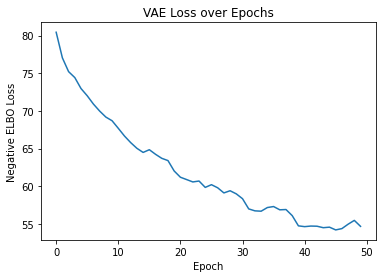

In [151]:
config["batch"] = 100
config["epoch"] = 50
config["lr"] = 1e-3
vae_train_dsprites(vae_dsprites, config, train_imgs=imgs[:30000])

In [152]:
vae_dsprites.to('cpu')
sampled_ims_post = vae_dsprites.sample_ims_from_prior(num_ims=5, train=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


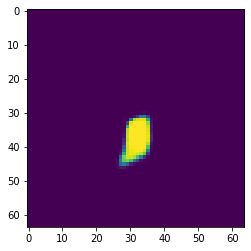

In [156]:
plt.imshow(F.sigmoid(sampled_ims_post[4,:,:]).squeeze().detach().numpy())

In [169]:
samples_like = vae_dsprites.sample_ims_like(torch.tensor(imgs[3,:,:]).float().view(1,1,64,64), num_ims=5, train=True)

In [170]:
samples_like = F.sigmoid(samples_like).squeeze().detach().numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [171]:
torch.save(vae_dsprites.state_dict(), "/content/VAE_dsprites_weights")

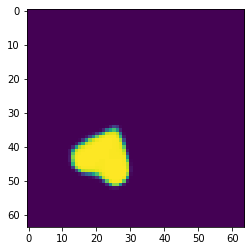

In [173]:
plt.imshow(samples_like[3,:,:])

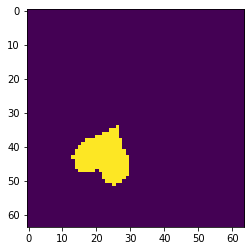

In [174]:
plt.imshow(torch.tensor(imgs[3,:,:]).float().detach().numpy())